In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
%matplotlib inline
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

## Polynomial Regression and Step Functions

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
Wage.columns

Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

In [5]:
# We wiil use the poly() funciton to creata a model matrix that will fit a 4th degree polynomial in age

poly_age = MS([poly('age',degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [6]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)


age_df = pd.DataFrame({'age':age_grid})

In [7]:
# Finally we wish to plot the data and add teh fit from the fourth degree polynomial. As we will make several similar plots below, we first write a funciton to create all the ingredients and produce the plot. Our funciton takes in a model specification, as well as a grid of age values. The funciton produces a fitted curve as well as 95% confidence bands. By using an argument for basis we can produce and plot the result swith several different transforms, such as the splines we will see shortly.


def plot_wage_fit(age_df, basis, title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y,X).fit()
    preds =  M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray', alpha=0.5)

    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1], ['b','r--','r--']]):
        ax.plot(age_df.values, val, ls, linewidth=3)
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    return ax

ValueError: not enough values to unpack (expected 2, got 1)

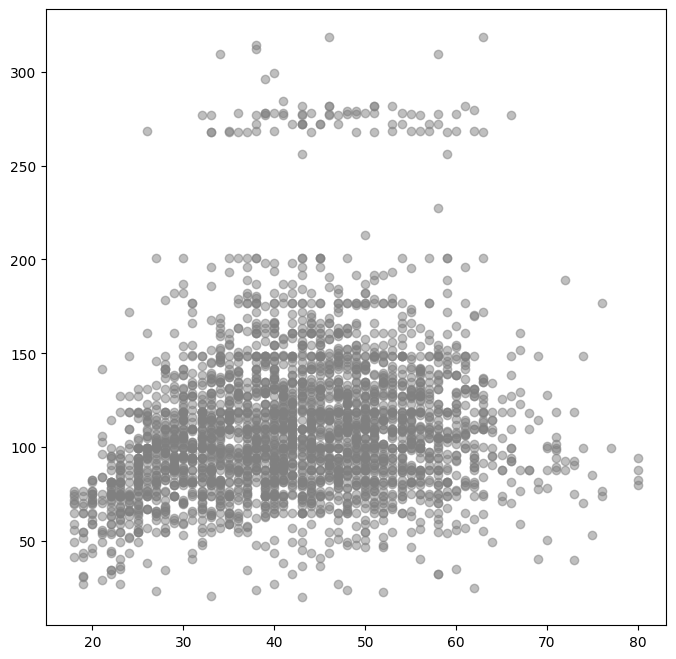

In [8]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial')

In [9]:
# With polynomial regression we must decide on the degree of the polynomial to use. Sometimes we just wing it, and decidt to use second or third degree polynomials, simply to obtain a nonlinear fit.


models = [MS([poly('age', degree=d)]) for d in range(1,6)]
Xs = [model.fit_transform(Wage) for model in models]


In [10]:
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [11]:
# As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using cross validation, as discussed. Next we consider the task of predicting whether an individual earns more than $250000 per year.


X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y>250, X, family=sm.families.Binomial())

B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [12]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)


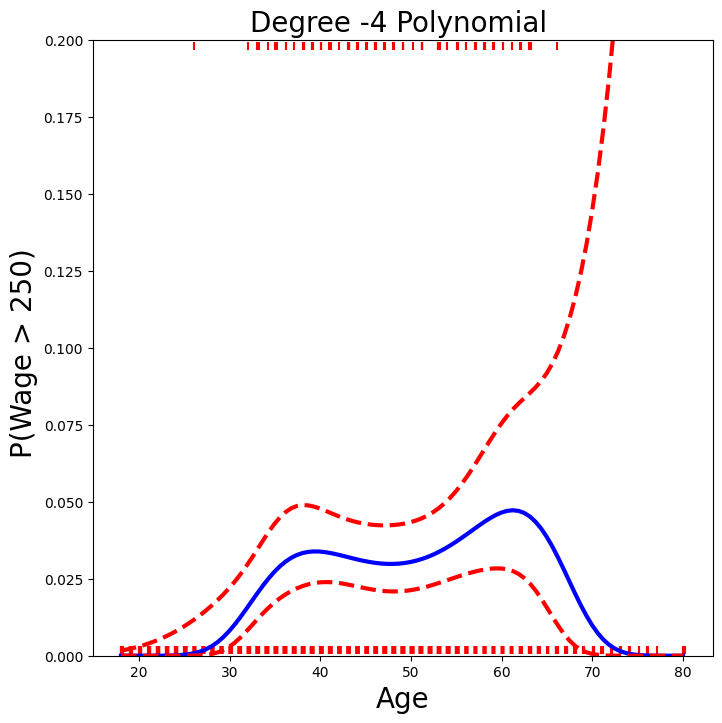

In [13]:
fig , ax = subplots(figsize =(8 ,8))
rng = np.random.default_rng (0)
ax.scatter(age +
0.2 * rng.uniform(size=y.shape [0]) ,
np.where(high_earn , 0.198 , 0.002) ,
fc='r',
marker='|')
for val , ls in zip([ preds.predicted_mean ,bands [:,0], bands [:,1]], ['b','r--','r--']):
    ax.plot(age_df.values , val , ls , linewidth =3)
ax.set_title('Degree -4 Polynomial ', fontsize =20)
ax.set_xlabel('Age', fontsize =20)
ax.set_ylim ([0 ,0.2])
ax.set_ylabel('P(Wage > 250) ', fontsize =20);

In [14]:
# We have drawn thea ge values corresponding to the observaitons with wage values above 250 as gray marks on the top of the plot, and those with wage values below 250 are shown as gray marks on the bottom of the plot. We added a small amount of noise to jitter the age values a bit so that observations with the same age value do not cover each other up. This type of plot is often called a rug plot.


cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


Splines

In [15]:
# In order to fit regression splines, we use transformas from the ISLP package, the actual spline  evaluation functions are in the scipy.interpolate package we have simply wrapped them as transforms similar to Poly() and PCA()


bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [16]:
# This results in a seven-column matrix, which is what is expected for a cubic spline basis with 3 interior knots. We can form this same matrix using the bs() object. which facilitates adding this to a model matrix builder


bs_age = MS([bs('age', internal_knots= [25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [17]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [18]:
bs_age0 = MS([bs('age',
                 df=3,
                 degree=0)]).fit(Wage)

Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [19]:
ns_age  = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


ValueError: not enough values to unpack (expected 2, got 1)

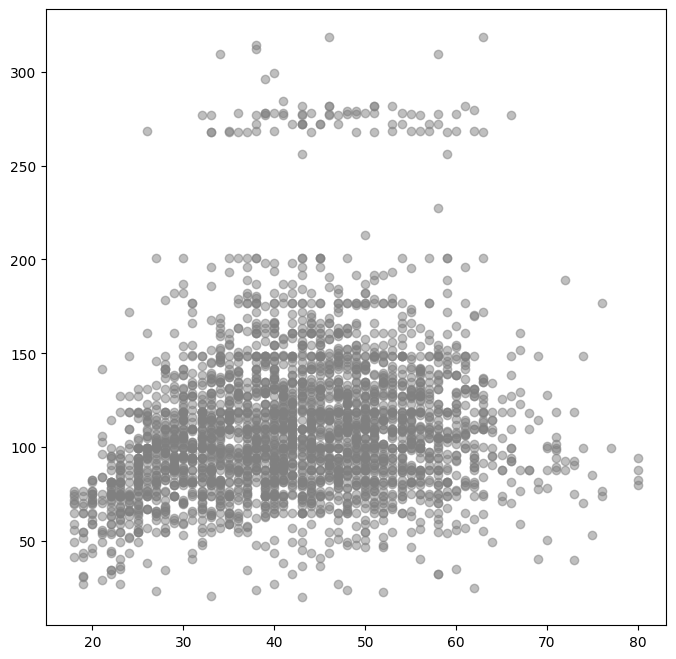

In [20]:
# We now plot teh natural spline using our plotting function

plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5')

## Smooting splines and GAMs

In [21]:
# A smoothing spline is a special case of a GAM with squared-error loss and a single feature. To fit GAMs in python we will use the pygam package which can be installed via pip install pygam. The estimator LinearGAM() uses squared-error loss. The GAM is specified by associating each column of a model matrix with a particular smoothing operationL s for smoothing spline;

# 1 for linear and f for factor or categorical variables. The argument 0 passed to s below indicated that this smoother will apply to the first column of a feature matrix. Below we pass it a matrix with a singel column: X_age.

# The argument lam is the penalty parameter lambda as discussed in sec 7.5.2

X_age = np.asarray(age).reshape(-1,1)
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

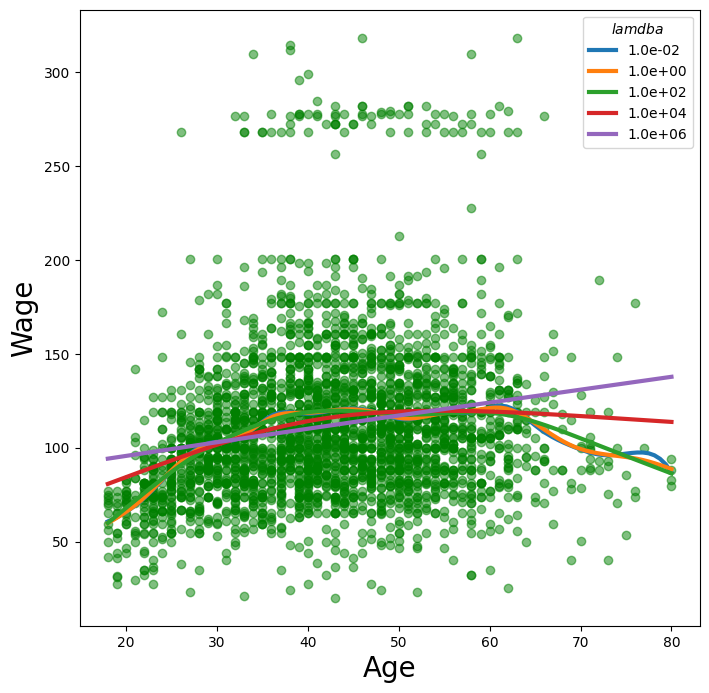

In [22]:
# The pygam library generally expects a matrix of features so we reshape age to be a matrix instead of a vector. The -1 in the call to the reshape() method tells numpy to impute the size of that dimension based on the remaining entries of the shape tuple.

# Lets investigate how the fit changes with the smoothing paramtere lam.

# The function np.logspace() is similar to np.linspace() but spaces points evenly on the log-scale. Below we vary lam form 10**-2 to 10**6


fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='g', alpha=0.5)

for lam in np.logspace(-2,6,5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)

ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='$lamdba$')


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


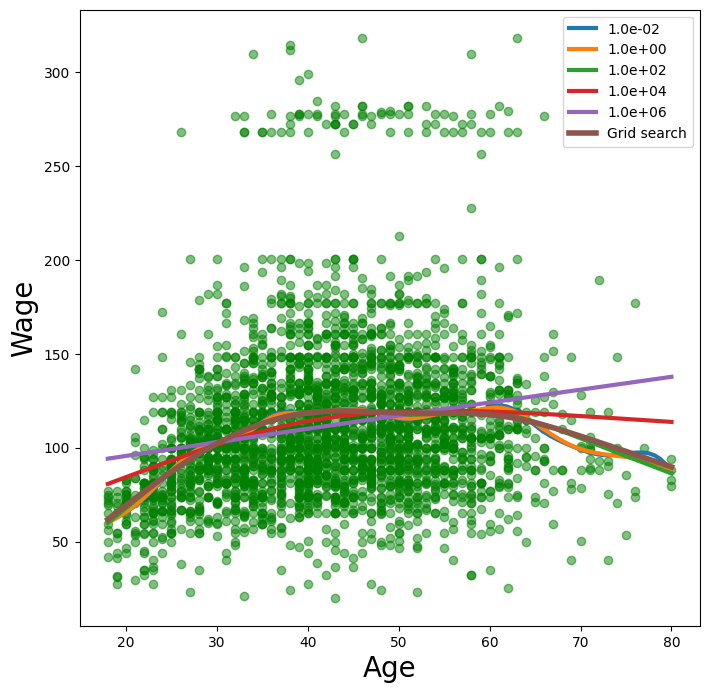

In [23]:
# The pygam package can perform a search for an optimal smoothing parameter

gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

In [24]:
# Also we can fix the degrees fo freedom of the smoothing spline using a function included in the ISLP.pygam package. Below we find a value of lambda that gives us roughtly four degrees of freedom.We not here that these degrees of freedom include the unpenalized interecept and linear term of the smoothing spline, hence there are at leaast two degrees of freedom.


age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100004728

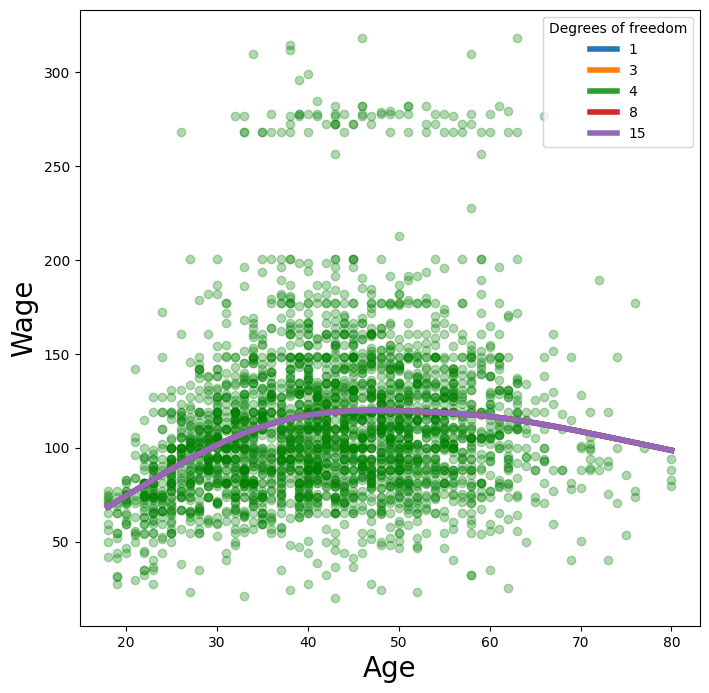

In [25]:
# Lets vary the degrees of freedom in a similar plot to above. We choose the degrees of freedom as the desired degrees of freedom plus one to account for the fact that these smoothing splines always have an interecept term.

# Hence a value of one for df is just a linear fit.


fig, ax= subplots(figsize=(8,8))
ax.scatter(X_age, y, facecolor='g', alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label = '{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='Degrees of freedom')

## Additive Models with Several Terms

In [26]:
# The strength of generalized additive models lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines and piecewise constant funcitons, and the second using the pygam package and smoothign splines.

In [27]:
# We now fita a GAM by hand to predict wage using natural spline functions of year and age. treating education as a qualitative predictor, as in 7.16. Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the sm.OLS() function..

# We will build the model matrix in a more manual fashion here, since we wish to access teh pieces separately when constructing partial dependence plots


ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]

X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

In [28]:
# Here the function NaturalSpline() is the workhorse supporting the ns() helper funciton. We chos e to use all columns of the indicatgor matrix for the categorical variable education, making an intercept redundant. finally we stacked the three component matrices horizontally to form the model matrix X_bh.


# We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand , give grids for age and year. WE simply predictt with new X amtrices, fixing all but one of the features at a time.


age_grid = np.linspace(age.min(),
                       age.max(),
                       100)

Text(0.5, 1.0, 'Partial dependence of age on wage')

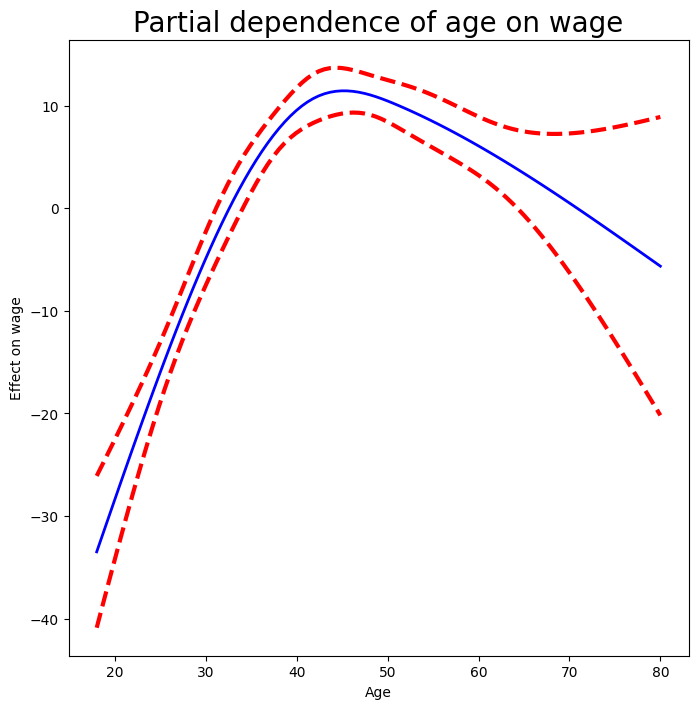

In [29]:
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)

preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)

partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=2)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20)

Text(0.5, 1.0, 'Partial dependence of year on wage')

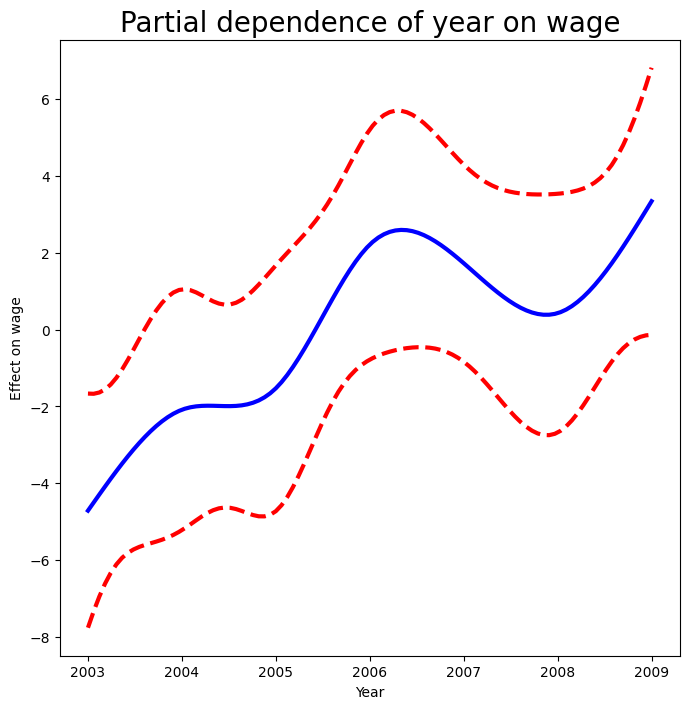

In [30]:
# Lets explain in some detail what we did above. The idea is to create a new prediction matrix. Where all but the columns belonging to age are constant. The four columns for age are filled in with the natural spline basis evalueated at the 100 values in age_grid.


# We made a grid of length 100 in age, and created a matrix X_age_bh with 100 rows and the smae number of columns as X_bh.

# We replaced every row of this matrix with the column means of the original

# We then replace just the first four columns representing age with the natural spline basis computed at the values in age_grid.

# The remaining steps should by now be familiar.
# We also look at the effect of year on wage: the process is the same.



year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(), Wage['year'].max(), 100)

X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]

X_year_bh[:, 4:9] = ns_year.transform(year_grid)

preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()


partial_year -= center
bounds_year -= center

fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

In [31]:
# We now fit the model using smoothing splines rather than natural splines. All of the terms  in are fit simultaneously, taking each other into account to explain the response. The pygam package only works with matrices, so we must convert the categorical series education to its array representation , which can be found with the cat.codes attribute of education. As year only ahs 7 uniques values, we use only seven basis functions for it.




gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0))
Xgam = np.column_stack([age, Wage['year'], Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

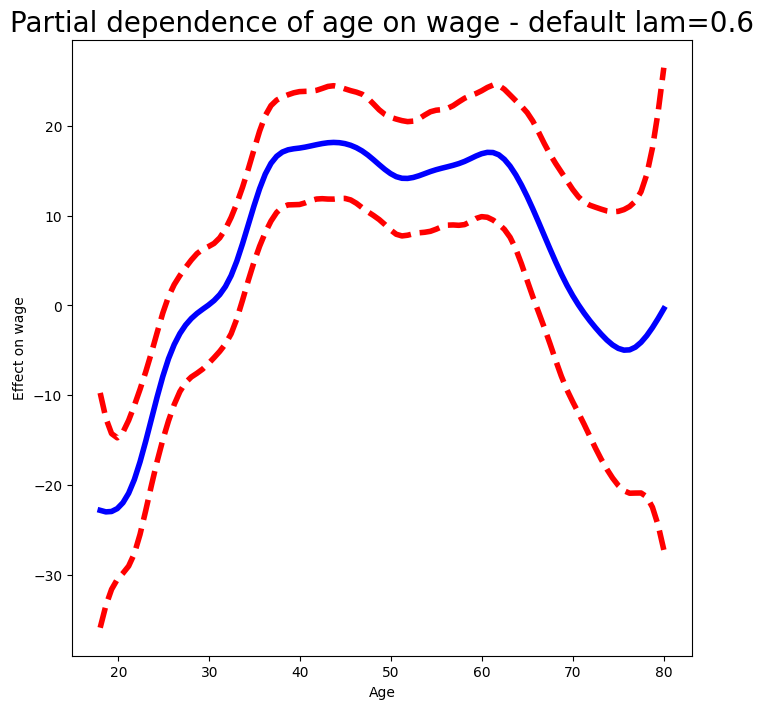

In [32]:
# The two s_gam() terms result in smoothing spline fits, and use a default value for lambda(lam=0.6) which is somewhat arbitrary. For the categorical term education. specified using a f_gam() term, we specify lam=0 to avoid any shrinkage. We produce the partial dependence plot in age to see the effect of these choices.


# The values for the plot are generated by the pygam package. WE provide a plot_gam() function  for partial-dependence plots in ISLP.pygam. which makes this job easier than in our last examples with natural splines.


fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20)

In [33]:
# We see that the funciton is somewhat wiggly. It is more natural to specify the df than a value for lam.We refit a GAM using four degrees of freedom each for age and year. Recall that the addition of one below takes into account the intercept of the smoothing spline.


age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of age on wage - default lam=0.6')

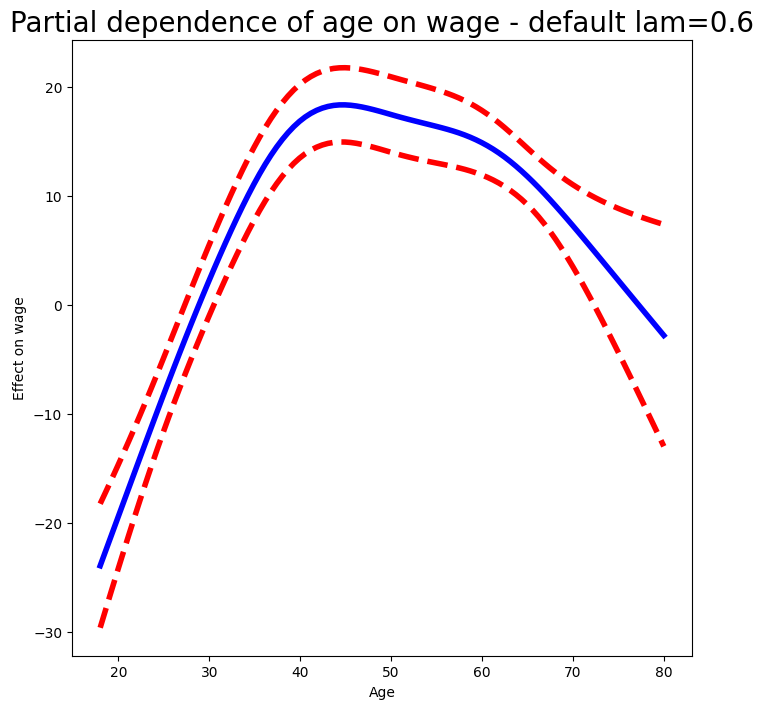

In [34]:
# The two s_gam() terms result in smoothing spline fits, and use a default value for lambda(lam=0.6) which is somewhat arbitrary. For the categorical term education, specified using a f_gam() term, we specify lam=0 to avoid any shrinkage. We produce the partial dependence plot in age to see the effect of these choices.


# The values for the plot are generated by the pygam mpackage. We provide a plot_gam() funciton for partial-dependence plots in ISLP.pygam, which makes this job easier than in our last example with natural splines.


fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20)

In [35]:
# We see that the funciton is somewhat wiggly. It is more natural to specify the df than a value for lam. We refit a GAM using four degrees of freedom each for age and year. Recall that the addition of one below takes into account the intercept of the smoothing spline.



age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of year on wage')

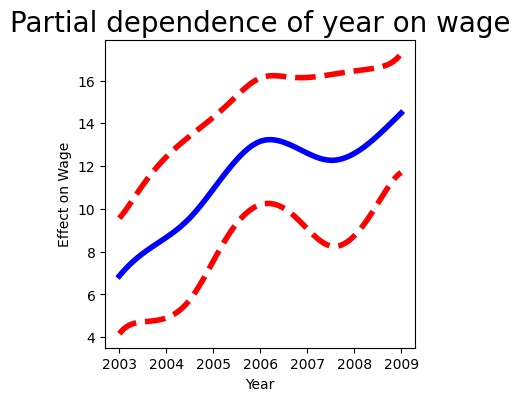

In [36]:
# Note that updating age_term.lam above updates it in gam_full.terms[0] as well likewise for year_term.lam


# Repeating the plot for age, we see that it is much smoother. WE also produce the plot for year.


fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

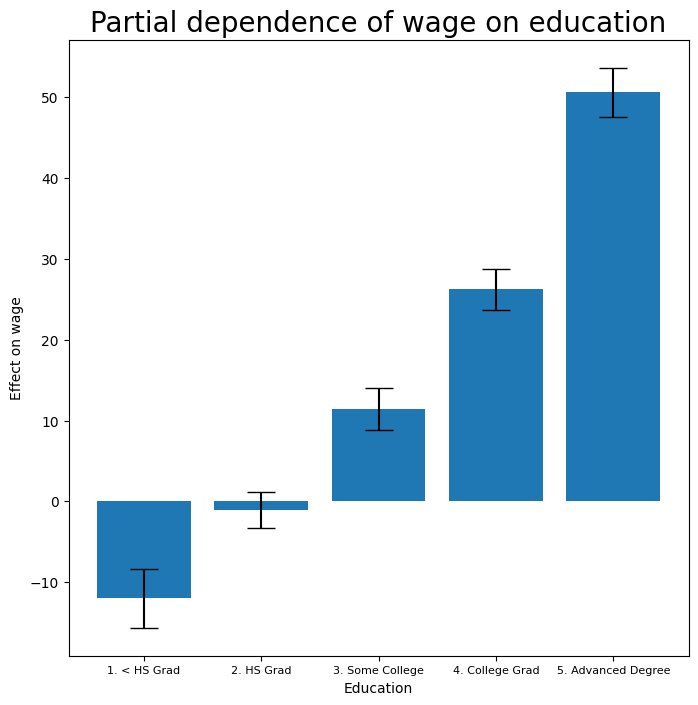

In [37]:
# Finally we plot education, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.


fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_full,2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20)

ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)

## ANOVA Tests for additive models

In [38]:
# In all of our models, the funciton of year looks rather linear. We can perform a series of ANOVA tests in order to determine which of these three models is best: a GAM that excludes year, a GAM that uses a linear function of year, or a GAM that uses a spline function of year.


gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))

gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [39]:
# Notice our use of age_term in the expressions above. We do this because earlier we set the value for lam in this term to achieve four degrees of freedomk.

# To directly assess the effect of year we run an ANOVA on the three models fit above..

anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [40]:
# We find that there is compelling evidence that a GAM with a linear function in year is better than a GAM that does not include year at all (p-value=0.002). However, there is no evidence that a non-linear function of year is needed. In other words, based on teh results of this ANOVA.M2 is preferred.


# We can repeat the same process for age as well. We see there is very clear evidence that a non linear term is required for age


gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))

gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [41]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipykernel_6429/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [44]:
# We can make predictions from gam objects, just like from lm objects, using the predict() method for the class gam.


Yhat = gam_full.predict(Xgam)
Yhat

array([ 52.3662492 ,  99.63834745, 111.7723448 , ...,  70.20962308,
        93.60649596, 104.91135937])

In [45]:
# In order to fit a logistic regression GAM, we use LogisticGAM() from pygam

gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

KeyError: 'education '

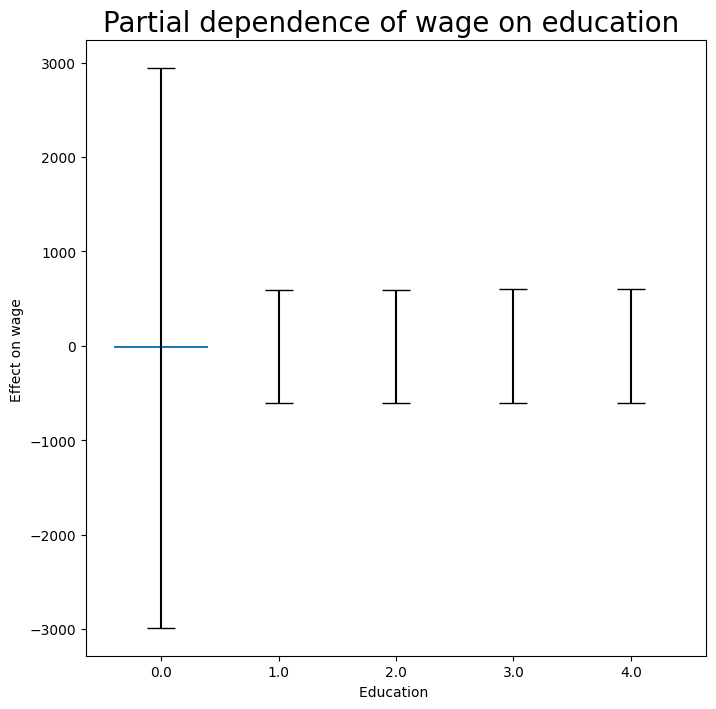

In [46]:
fig , ax = subplots(figsize =(8, 8))
ax = plot_gam(gam_logit , 2)
ax.set_xlabel('Education ')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of wage on education ',
fontsize =20);
ax.set_xticklabels(Wage['education '].cat.categories , fontsize =8);

In [47]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [48]:
# We see that there are no high earners in the first category of education, meaning that the model will have a hard time fitting. We will fit a logistic regression GAM excluding all observations falling into this category. This provides more sensible results.

# To do so, we could subset the model matrix, though this will not remove the column from Xgam. Whiel we can deduce which column corresponds to this feature, for reproducibility's sake we reform the model matrix on this smaller subset.


only_hs = Wage['education'] =='1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])

high_earn_ = Wage_['high_earn']

In [51]:
gam_logit_ = LogisticGAM(age_term + year_term + f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

[Text(0, 0, '2. HS Grad'),
 Text(1, 0, '3. Some College'),
 Text(2, 0, '4. College Grad'),
 Text(3, 0, '5. Advanced Degree')]

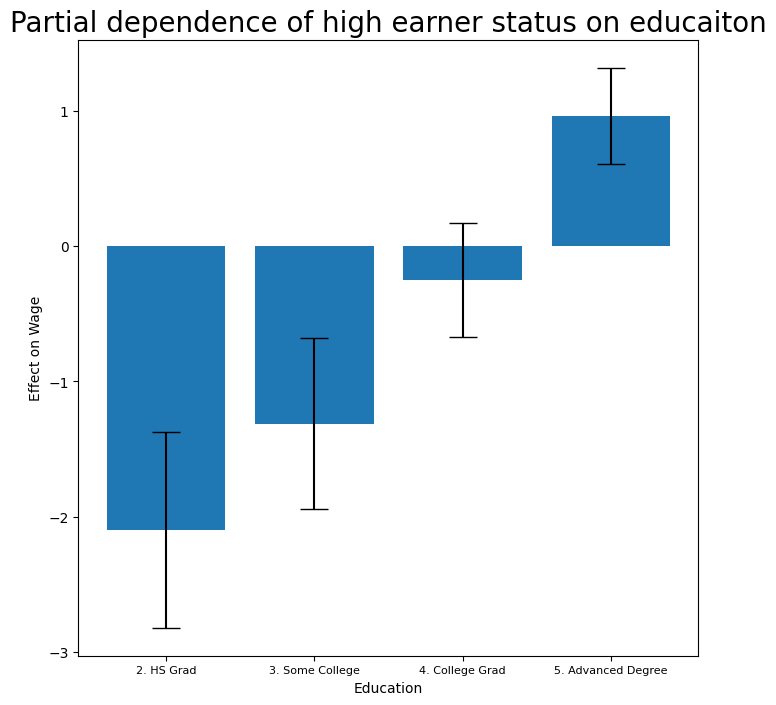

In [52]:
# Lets look at the effect of educaiton ,year and age on high earner status now that we have removed those observations.

fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of high earner status on educaiton', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories[1:], fontsize=8)

Text(0.5, 1.0, 'Partial depend')

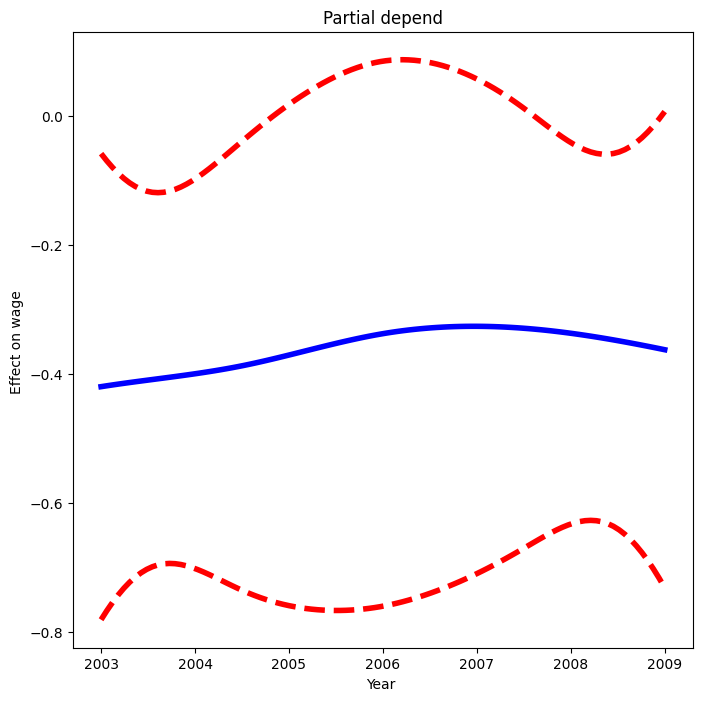

In [55]:
fig , ax = subplots(figsize =(8, 8))
ax = plot_gam(gam_logit_ , 1)
ax.set_xlabel('Year ')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial depend')

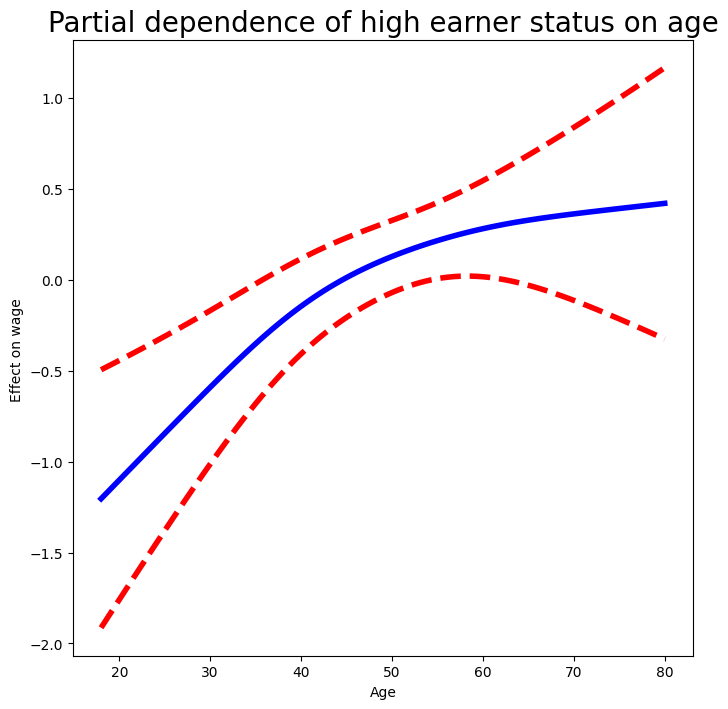

In [56]:
fig , ax = subplots(figsize =(8, 8))
ax = plot_gam(gam_logit_ , 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of high earner status on age',
fontsize =20);

## Local Regression